In [27]:
import torch 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def visualize(outputs):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
    
    name = outputs["name"]
    lr = outputs["lr"]
    loss = outputs["loss"]
    trans = outputs["trans"]
    epochs = range(len(lr))

    fig.suptitle(name)
    axes[0].set_title("Learning Rate")
    axes[0].plot(epochs, lr)

    axes[1].set_title("Loss")
    axes[1].plot(epochs, loss)

    if trans:
        M, m = max(loss), min(loss)
        for epoch in trans:
            axes[0].scatter(epoch, lr[epoch], color="red", marker="*")
            axes[0].text(epoch, lr[epoch], s=f"lr:{lr[epoch]:.8f}")

            axes[1].vlines(epoch, m , M, linestyles="--", color="gray")
            axes[1].text(epoch, M, s=round(loss[epoch], 4))
    plt.tight_layout()
    plt.savefig(f"lr/{name}.png")
    plt.show()
            

## Learning Rate란?
- Learning Rate(학습률)은 모델이 얼마나 크게 가중치를 업데이트할지를 결정하는 값
- 즉, 학습 속도를 결정하는 파라미터
  - **값이 너무 크면** 최적점을 지나 발산
  - **값이 너무 작으면** 학습이 너무 오래 걸려 비용이 증가
  - 따라서 적절한 값으로 조절이 필요
## Scheduler
- 학습 시 Learning rate를 조정하는 전략
  - 학습 초기: 큰 lr 값으로 전역 구조를 빠르게 탐색
  - 학습 후기: 작은 lr값으로 미세 조정
- 효과
  - 더 안정적인 수렴: 처음엔 빠르게 학습하고 나중엔 천천히 세밀하게 조정
  - local minima 탈출 가능: 중간에 lr을 높이거나 변동시켜 더 좋은 점을 찾을 수 있음
  - 학습 시간 단축: 초반엔 큰 lr로 빠르게 학습
  - 과적합 방지: 후반에 lr를 줄이면 loss 변동이 줄고, overgitting완화 효과
  - 일반화 성능 향상: 부드럽게 감소시키면 테스트 데이터에서도 좋은 결과
## WarmUp
- 학습 초기에는 lr을 아주 작게 시작해서 조금씩 키우는 과정
- 처음부터 큰 lr로 학습하지 않고 천천히 "워밍업"
- 효과
  - 훈련 초기 불안정성 방지
    - 큰 lr로 시작하면 loss가 갑자기 발산하거나 gradient가 튈 수 있음
    - warmup으로 조금씩 lr을 올리면서 안정적으로 학습 시작 가능
  - 큰 batch / deep model에서 효과적
    - batch size가 크거나 Transformer 와 같은 깊은 모델에서는 초기 lr이 너무 크면 학습 불안정
    - warmup으로 안정화 후 본격적인 lr 스케줄링 적용
  - 성능 향상
    - 특히 BERT, GPT, Vision Transfomer와 같은 최신 모델들은
    - WarmUP + Cosine LR 조합이 기본 세팅

In [24]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(30, 1)
    def forward(self, x):
        return self.layer(x)

x, y = make_classification(n_samples=1000000, n_features=30)
y = y.reshape(-1, 1)
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([900000, 30]),
 torch.Size([900000, 1]),
 torch.Size([100000, 30]),
 torch.Size([100000, 1]))

## StepLR
- 정의
  - 일정한 epoch간격(step_size)마다 학습룰을 일정 비율(gamma)로 줄이는 방식
  - 한동안은 그대로, 어느 시점에서 툭 줄어듬
- 작동 원리
  - epoch가 step_size의 배수가 되면
  - $lr = lr * gamma$
- 기대 효과
  - 단계적으로 학습 속도를 늦춰 안정적인 수렴을 유도
  - 단순하고 튜닝이 쉽다
  - 기본 모델에서 자주 사용됨

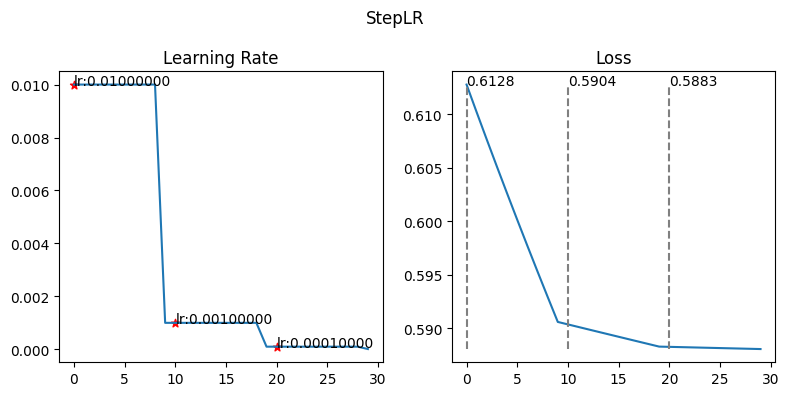

In [28]:
result = {
    "name":"StepLR",
    "lr":[],
    "loss":[],
    "trans":[],
}

epochs = 30
lr = 0.01

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10,
    gamma=0.1,
)


for epoch in range(epochs):
    model.train()
    
    # forward
    logits = model(x_train)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_train)
    

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        logits = model(x_test)
        val_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_test)
        
        

    scheduler.step()
    result["loss"].append(val_loss.item())
    result["lr"].append(scheduler.get_last_lr()[0])
    if epoch % 10 == 0:
        result["trans"].append(epoch)

visualize(result)

## CosineAnnealingLR
- 정의
  - 학습률을 Cosine 함수 형태로 부드럽게 감소시키는 스케줄러
  - 초반에는 완만하게, 후반에는 급격하게 감소함
- 작동 원리
  - $\eta_{t+1} = \eta_{min} + (\eta_t-\eta_{min})\cdot\frac{1+cos(\frac{(T_{cur}+1)\pi}{T_{max}})}{1+cos(\frac{T_{cur}\pi}{T_{max}})}$
  - approximation $\rightarrow \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left( 1 + cos(\frac{T_{cur}\pi}{T_{max}}) \right)$
  - $\eta_t$: step t에서의 learning rate
  - $T_{cur}$: last restart에서부터 epoch 수
  - $T_{max}$: 한 cycle에서 epochs 최대 값
- 기대 효과
  - 부드럽게 lr를 줄여서 모델이 끝부분에서 더 정교하게 수렴
  - 일반화 성능 향상(테스트 정확도 증가)
  - 긴 학습에 적합(ImageNet, Transfomrer 등)

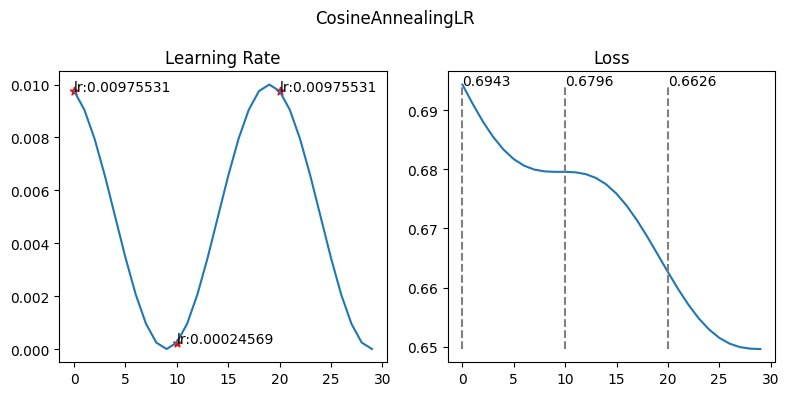

In [29]:
result = {
    "name":"CosineAnnealingLR",
    "lr":[],
    "loss":[],
    "trans":[]
}

epochs = 30
lr = 0.01

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs//3, # t_max epoch 동안 lr이 최대 -> 최소로 감소
    eta_min=lr * 0.0001,
)


for epoch in range(epochs):
    model.train()
    
    # forward
    logits = model(x_train)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_train)
    

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        logits = model(x_test)
        val_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_test)
        
        

    scheduler.step()
    result["loss"].append(val_loss.item())
    result["lr"].append(scheduler.get_last_lr()[0])
    if epoch % 10 == 0:
        result["trans"].append(epoch)

visualize(result)

## ReduceLROnPlateau
- 정의
  - validation loss가 개선되지 않을 때만 학습률을 줄이는 방식
  - 모델이 더 이상 좋아지지 않을 때, lr을 낮춰 다시 fine-tuning하는 방식
  - Plateau: 특정 수준에 도달한 후 발전이나 성장이 멈추는 정체기
- 작동원리
  - 일정 기간(patience) 동안 validation loss가 좋아지지 않으면 lr를 감소
  - lr = lr * factor
- 기대효과
  - 자동으로 최적 시점에 lr을 조정
  - fine-tuning이나 transfer learning에 매우 유용
  - 불필요한 lr 감소를 방지하여 효율적 학습 유도

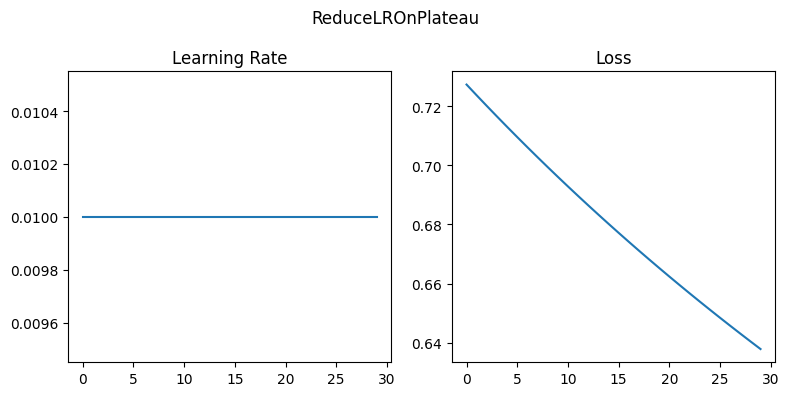

In [31]:
result = {
    "name":"ReduceLROnPlateau",
    "lr":[],
    "loss":[],
    "trans":[],
}

epochs = 30
lr = 0.01

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.1,
    patience=5
)

for epoch in range(epochs):
    model.train()
    
    # forward
    logits = model(x_train)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_train)
    

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        logits = model(x_test)
        val_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_test)
        
        

    scheduler.step(metrics=val_loss)
    result["loss"].append(val_loss.item())
    result["lr"].append(scheduler.get_last_lr()[0])

visualize(result)

## OneCycleLR
- 정의
  - 학습 초기에 lr을 점점 올렸다가 이후 점점 줄이는 한 주기(one cycle) 형태의 scheduler
  - fastai나 modern deep learning에서 인기
- 작동원리
  - 총 학습 기간을 하나의 cycle로 보고 초반에는 lr을 based_lr에서 max_lr까지 증가
  - 이후 천천히 감소
- 기대효과
  - 초반에는 큰 lr로 global minimum 근처 탐색
  - 후반에 작은 lr로 세밀하게 수렴
  - 학습 속도 빠름 + 일반화 성능 우수
  - fine-tuning에서 많이 사용

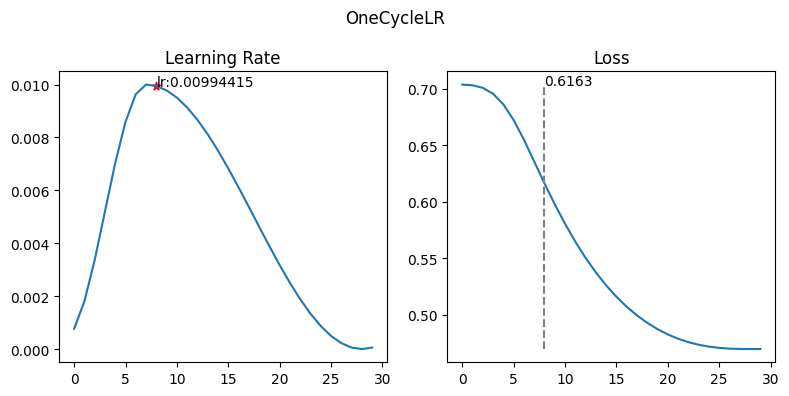

In [45]:
result = {
    "name":"OneCycleLR",
    "lr":[],
    "loss":[],
    "trans":[]
}

epochs = 30
lr = 0.01

pct_start = 0.3
model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr = lr,
    steps_per_epoch=1, # len(dataloader)
    pct_start=pct_start,
    epochs=epochs,
)

for epoch in range(epochs):
    model.train()
    
    # forward
    logits = model(x_train)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_train)
    

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        logits = model(x_test)
        val_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_test)
        
        

    scheduler.step()
    result["loss"].append(val_loss.item())
    result["lr"].append(scheduler.get_last_lr()[0])
    if epoch+1 == int(scheduler.total_steps * pct_start):
        result["trans"].append(epoch)

visualize(result)

## Warmup을 적용한 Learning Rate with scheduler

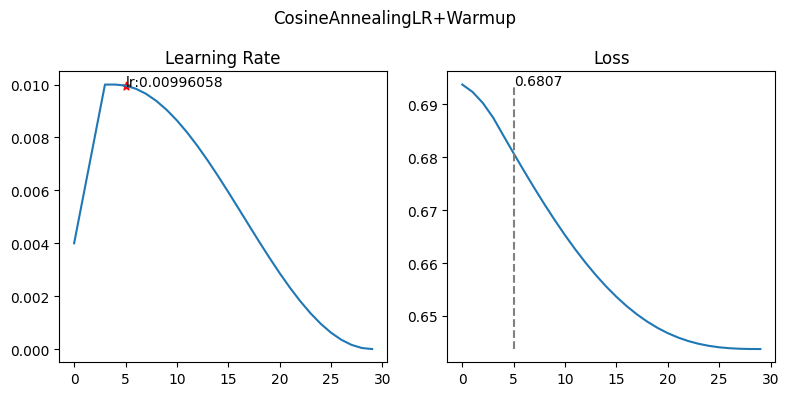

In [46]:
import math
class CosineAnnealingWarmUpLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, total_epochs, warmup_epochs=5, eta_min=0, last_epoch=-1):
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.eta_min = eta_min
        super().__init__(optimizer, last_epoch)
        
    def get_lr(self):
        lrs = []
        for base_lr in self.base_lrs:
            if self.last_epoch < self.warmup_epochs:
                # linear warmup
                lr = base_lr * (self.last_epoch + 1) / self.warmup_epochs
            else:
                # cosine decay
                progress = (self.last_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
                lr = self.eta_min + 0.5 * (base_lr - self.eta_min) * (1 + math.cos(math.pi * progress))
            lrs.append(lr)
        return lrs
    

result = {
    "name":"CosineAnnealingLR+Warmup",
    "lr":[],
    "loss":[],
    "trans":[5] # warmup_epochs
}

epochs = 30
lr = 0.01
warmup_epochs = 5  # 처음 5 epoch 동안 warmup
eta_min = lr * 0.0001

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = CosineAnnealingWarmUpLR(
    optimizer=optimizer, 
    total_epochs=epochs,
    warmup_epochs=warmup_epochs, 
    eta_min=eta_min,
    last_epoch=-1,
)

for epoch in range(epochs):
    model.train()
    
    # forward
    logits = model(x_train)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # validation
    model.eval()
    with torch.no_grad():
        logits = model(x_test)
        val_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y_test)
    
    # scheduler step
    scheduler.step()
    
    result["loss"].append(val_loss.item())
    result["lr"].append(optimizer.param_groups[0]['lr'])

visualize(result)